In [78]:
import pandas as pd
import numpy as np
import sklearn.feature_extraction.text as sk_text
import string
from sklearn.model_selection import train_test_split

from sklearn import tree, metrics    # Decision Tree
from sklearn.linear_model import LogisticRegression # LogisticRegression
from sklearn.svm import SVC # Support Vector Machine 
from joblib import dump, load
import matplotlib.pyplot as plt


In [3]:
%%time
#reading in only 500k records
toxic_comments_df = pd.read_csv('train.csv',nrows=100000)
toxic_comments_df =  toxic_comments_df[['id','target','comment_text']]


CPU times: user 972 ms, sys: 111 ms, total: 1.08 s
Wall time: 1.15 s


In [4]:
#creating our truth column. comment is toxic if target >= .5
toxic_comments_df['truth'] = toxic_comments_df.target.apply(lambda x: 1 if x>=.5 else 0 ).astype('float32')
toxic_comments_df.head()


,id,target,comment_text,truth
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.0
3,59855,0.000000,Is this something I'll be able to install on m...,0.0
4,59856,0.893617,haha you guys are a bunch of losers.,1.0


In [5]:
toxic_comments_df['InputData'] = toxic_comments_df['comment_text'].str.replace('[{}]'.format(string.punctuation), '')
toxic_comments_df['InputData'] = toxic_comments_df['InputData'].apply(lambda x: " ".join([ word.lower() if word[0].isalpha() else ""  for word in str(x).split()]))

toxic_comments_df.head()

,id,target,comment_text,truth,InputData
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.0,this is so cool its like would you want your m...
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.0,thank you this would make my life a lot less a...
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.0,this is such an urgent design problem kudos to...
3,59855,0.000000,Is this something I'll be able to install on m...,0.0,is this something ill be able to install on my...
4,59856,0.893617,haha you guys are a bunch of losers.,1.0,haha you guys are a bunch of losers


In [6]:
vectorizerInput = sk_text.CountVectorizer(#max_features = 10000,
                             min_df=.001, 
                             #max_df=.75,
                            stop_words=['id','truth']
                            )
matrix = vectorizerInput.fit_transform(toxic_comments_df.InputData.values)
print("# of features", len(vectorizerInput.get_feature_names()))


# of features 3929


In [7]:
%%time
df_text = pd.DataFrame(matrix.todense(), index=toxic_comments_df.id, columns=vectorizerInput.get_feature_names()).astype('float32')

dataFrameWithHashTagHandlesAndTruths = pd.merge(df_text,  toxic_comments_df[['id','truth']].copy(), on='id').astype('float32')


CPU times: user 16.3 s, sys: 7.08 s, total: 23.4 s
Wall time: 21.4 s


In [8]:
%%time
X = dataFrameWithHashTagHandlesAndTruths.drop(['id','truth'], axis=1)
y = dataFrameWithHashTagHandlesAndTruths.truth.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 3929)
(80000,)
(20000, 3929)
(20000,)
CPU times: user 2.51 s, sys: 1.14 s, total: 3.65 s
Wall time: 3.74 s


## Logistic Regression ##

In [ ]:
%%time
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
best_scores = []
best_models = []
for current_solver in solvers:
        logreg = LogisticRegression(solver=current_solver)
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)
        best_scores.append(metrics.f1_score(y_test, y_pred, average='weighted'))
        best_models.append(current_solver)
        

best_solver = max(best_scores)

print('Best Scores:')    
print(best_scores)
print()
print('Best Models:')
print(best_models)
print()
print('Overall Best Score:')
print(best_solver)



In [9]:
%%time
##best solver is newton-cg
logreg = LogisticRegression(solver=best_solver)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print(metrics.precision_score(y_test, y_pred_logreg, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred_logreg, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred_logreg, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred_logreg))

0.9310666074332825
0.94175
0.9328402646445451
[[18407   256]
 [  909   428]]
CPU times: user 7min 4s, sys: 44.5 s, total: 7min 49s
Wall time: 5min 11s


In [11]:
dump(logreg, 'LogisticRegression.joblib') 

['logreg.joblib']

## Decision Tree ##

In [12]:
%%time
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

print(metrics.precision_score(y_test, y_pred_clf, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred_clf, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred_clf, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred_clf, labels=[0, 1]))

0.9175298704711424
0.9195
0.9184933530352853
[[17893   770]
 [  840   497]]
CPU times: user 6min 12s, sys: 2.64 s, total: 6min 15s
Wall time: 6min 24s


In [14]:
dump(clf, 'DecisionTree.joblib') 

['decisionTree.joblib']

## Neural Network ##

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
scaler = StandardScaler()
scaler.fit(X_train)
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

/Users/jashmit/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jashmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """
/Users/jashmit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  


In [20]:
%%time
mlp = MLPClassifier(hidden_layer_sizes=(500,500), solver = 'adam')
mlp.fit(X_train_nn,y_train)
y_pred_mlp = mlp.predict(X_test_nn)

print(metrics.precision_score(y_test, y_pred_mlp, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred_mlp, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred_mlp, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred_mlp, labels=[0, 1]))

0.9283957231860063
0.9389
0.9313981771975992
[[18328   335]
 [  887   450]]
CPU times: user 48min 20s, sys: 3min 2s, total: 51min 22s
Wall time: 26min 31s


In [93]:
print(metrics.classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     18663
         1.0       0.57      0.34      0.42      1337

   micro avg       0.94      0.94      0.94     20000
   macro avg       0.76      0.66      0.70     20000
weighted avg       0.93      0.94      0.93     20000



In [21]:
dump(mlp, 'MLP.joblib') 

['MLP.joblib']

## Gaussian Naive Bayes #

In [15]:
%%time
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred_gaus = gnb.fit(X_train, y_train).predict(X_test)

print(metrics.precision_score(y_test, y_pred_gaus, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred_gaus, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred_gaus, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred_gaus, labels=[0, 1]))

0.9097845061901335
0.38455
0.4919719076099039
[[ 6565 12098]
 [  211  1126]]


In [16]:
dump(gnb, 'Gaussian.joblib') 

['GAUS.joblib']

## Bernoulli Naive Bayes ##

In [17]:
%%time
from sklearn.naive_bayes import BernoulliNB
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred_bern=bern.predict(X_test)

print(metrics.precision_score(y_test, y_pred_bern, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred_bern, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred_bern, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred_bern, labels=[0, 1]))

0.9204199260431624
0.91435
0.9172134116975269
[[17702   961]
 [  752   585]]


In [18]:
dump(bern, 'Bernoulli.joblib') 

['BERN.joblib']

## Multinomial Naive Bayes #

In [86]:
%%time
from sklearn.naive_bayes import MultinomialNB
multi = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
multi.fit(X_train, y_train)
y_pred_multi=bern.predict(X_test)

print(metrics.precision_score(y_test, y_pred_multi, average= 'weighted'))
print(metrics.recall_score(y_test, y_pred_multi, average= 'weighted'))
print(metrics.f1_score(y_test, y_pred_multi, average= 'weighted'))
print(metrics.confusion_matrix(y_test, y_pred_multi, labels=[0, 1]))

0.9204199260431624
0.91435
0.9172134116975269
[[17702   961]
 [  752   585]]
CPU times: user 7.06 s, sys: 1.66 s, total: 8.73 s
Wall time: 7.88 s


In [87]:
dump(bern, 'Multinomial.joblib') 

['Multinomial.joblib']

## Read in models to calculate F1 Scores ##

In [89]:
f1_scores=[]
model_files=['LogisticRegression.joblib','DecisionTree.joblib','MLP.joblib','Bernoulli.joblib','Multinomial.joblib','Gaussian.joblib']
for model in model_files:
    y_pred = load(model).predict(X_test)
    f1_scores.append(metrics.f1_score(y_test, y_pred, average= 'weighted'))
print("F1 Scores",f1_scores)


F1 Scores [0.9328402646445451, 0.9184933530352853, 0.9057324071885223, 0.9172134116975269, 0.9172134116975269, 0.4919719076099039]


## Plot F1-Scores ##

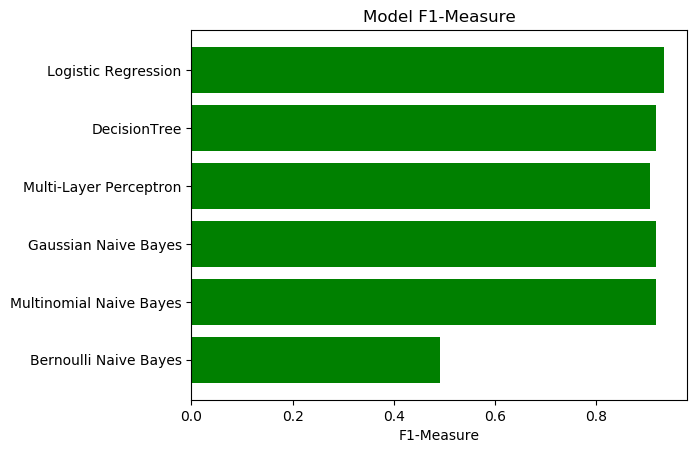

In [91]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos_on_graph = np.arange(len(model_files))
ax.barh(y_pos_on_graph, f1_scores,align='center',color='green', ecolor='black')
ax.set_yticks(y_pos_on_graph)
ax.set_yticklabels(['Logistic Regression','DecisionTree','Multi-Layer Perceptron','Gaussian Naive Bayes','Multinomial Naive Bayes','Bernoulli Naive Bayes'])
ax.invert_yaxis() 
ax.set_xlabel('F1-Measure')
ax.set_title('Model F1-Measure')

plt.show()

## Load in models to show ROC-AUC Curve ## 

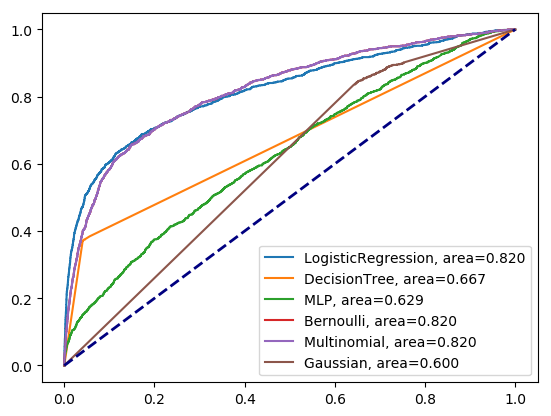

In [92]:
for model in model_files:
    y_pred_proba = load(model).predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label=model.split('.')[0]+", area=%.3f"%auc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.legend(loc=4)
plt.show()

# Output predictions #

In [ ]:
toxic_comments_df_test = pd.read_csv('test.csv')
matrix = vectorizerInput.transform(toxic_comments_df_test.comment_text.values)
df_text = pd.DataFrame(matrix.todense(), index=toxic_comments_df_test.id, columns=vectorizerInput.get_feature_names()).astype('float32')
y_pred_test = logreg.predict(df_text)

In [ ]:
#Save results to output file
toxic_comments_df_test['prediction'] = y_pred_test
#toxic_comments_df_test.drop(['comment_text'],axis=1).to_csv('submission.csv')